In [28]:
import pandas as pd
from pathlib import Path
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature  as cfeature
import geopandas as gpd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,\
    RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,\
    MinMaxScaler,StandardScaler, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.compose import TransformedTargetRegressor,make_column_selector,make_column_transformer,ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import binom
from sklearn import set_config
from sklearn.metrics import r2_score,root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, expon, loguniform
from scipy import stats
import joblib
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel

In [2]:
rng = np.random.default_rng(seed=42)
set_config(display='diagram')

In [3]:
def load_housing_data():
    tarball_path = Path('datasets/housing.tgz')
    if not tarball_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
        url = 'https://github.com/ageron/data/raw/main/housing.tgz' # datapatH
        urllib.request.urlretrieve(url,tarball_path)                # gets the data and puts it in the cheked path
        with tarfile.open(tarball_path) as housing_tarball:         # read the data the data from the checked path
            housing_tarball.extractall(path='datasets')             # extract the data into the checked folder
    return pd.read_csv(Path('datasets/housing/housing.csv'))        # pd read the file 

housing  = load_housing_data()

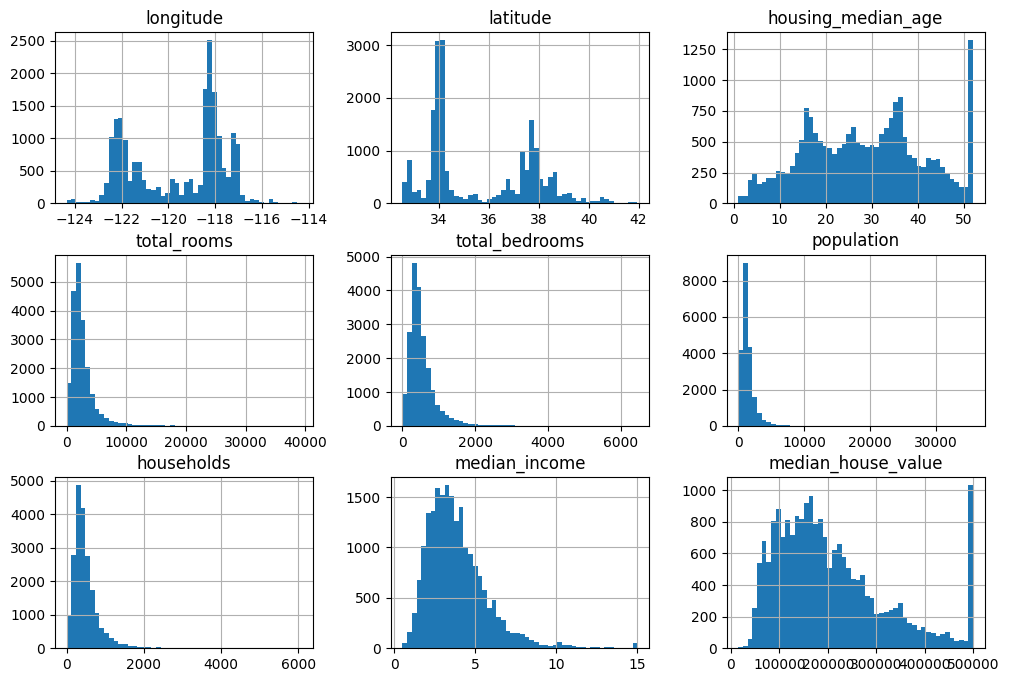

In [4]:
housing.hist(bins= 50, figsize=(12,8))
plt.show()

In [5]:
def shuffle_split_data(data, test_ratio):
    rng = np.random.default_rng(seed=42)
    data_shuffle = rng.permutation(len(data))
    test_set_size = int(test_ratio*len(data))
    test_indices = data_shuffle[:test_set_size]
    train_indices = data_shuffle[test_set_size:]
    return data.loc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_split_data(housing, 0.2)
print(f'Len for train set {len(train_set)}, Len of test set {len(test_set)}')

Len for train set 16512, Len of test set 4128


In [6]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing['income_cats'] = pd.cut(housing['median_income'], bins = [0,1.5,3,4.5,6,np.inf], labels=[1,2,3,4,5])
housing['combined'] =housing.apply(lambda x: '_'.join(x.values.astype(str)), axis=1)

htrain,htest = train_test_split(housing, test_size=.2,stratify=housing['income_cats'], random_state=42)

In [7]:
for set_ in (htrain, htest):
    set_.drop(['combined', 'income_cats'], axis = 1, inplace=True)

In [8]:
housing = htrain.copy()

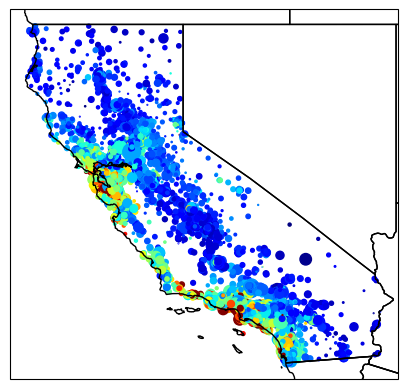

In [9]:
# initializing the map
ax = plt.axes(projection = ccrs.PlateCarree())

# Addingfeatures
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linestyle='-')

# Plotting lat and long
ax.scatter(housing['longitude'], housing['latitude'], marker = 'o', s = housing['population']/100, label = 'population',c = housing['median_house_value'], cmap='jet')

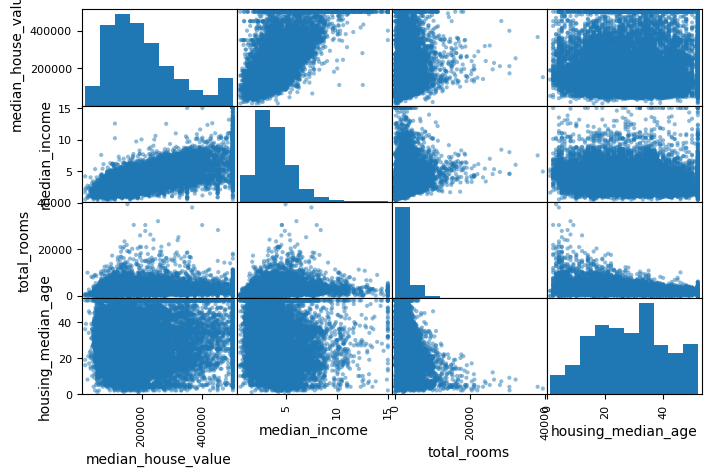

In [10]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

pd.plotting.scatter_matrix(housing[attributes], figsize=(8,5))
plt.show()

In [11]:
housing = htrain.drop('median_house_value',axis=1)
housing_label = htrain['median_house_value'].copy()

In [14]:
imputer = SimpleImputer(strategy='median')
housing_num = housing.select_dtypes(include=[np.number])
X = imputer.fit_transform(housing_num)

# recovering dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [15]:
housing_cat = housing[['ocean_proximity']]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
cat_encoder.feature_names_in_
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [16]:
# extra code – shows another way to estimate the probability of bad sample
# math
sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

# simulation
np.random.seed(42)

samples = (np.random.rand(100000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.10736798530929942


0.1071

In [17]:
# Feature Scaling and transformation
min_max_scalar = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scalar.fit_transform(housing_num)

std_scalar = StandardScaler()
housing_num_std_sclaed = std_scalar.fit_transform(housing_num)

## Radial basis function
age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)

## simple linear model
model  = TransformedTargetRegressor(LinearRegression(),transformer=StandardScaler())
model.fit(housing[['median_income']], housing_label)
predictions = model.predict(housing[['median_income']][:5])

In [12]:
# Custom Transformers
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing['population'])

rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y = [[35]],gamma = .1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])

sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y = [sf_coords], gamma = .1))
sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])

## Combining features
ratio_transformer = FunctionTransformer(lambda x: x[:,[0]]/x[:,[1]])
xt = np.array([[1,2],[3,4]])
ratio_transformer.transform(xt)

## Custom StandardScaler
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean = True): #no args or kwargs
        self.with_mean = with_mean
        
        
    def fit(self, X, y = None): # y is required even though we dont use it
        X = check_array(X)      # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] #every estimator stores this in fit()
        return self # always return self
    
    def transform(self,X):
        check_is_fitted(self) #looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
            return X / self.scale_
        
        
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    """ The fit method identifies clusters using KMeans clustering and the transform method checks 
    for similiratity between a data point and against all the clusters identified by the KMeans clustering fit method
    
    Args:
        BaseEstimator (_type_): _description_
        TransformerMixin (_type_): _description_
    """
    def __init__(self, n_clusters = 10, gamma = .1, random_state= None) -> None:
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X, y = None, sample_weight = None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names = None):
            return [f'Cluster {i} similarity' for i in range(self.n_clusters)]
        
## using custom tranformer
cluster_simil = ClusterSimilarity(n_clusters = 10, gamma=1., random_state=42)
similarity = cluster_simil.fit_transform(housing[['latitude','longitude']],sample_weight = housing_label)

similarity[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

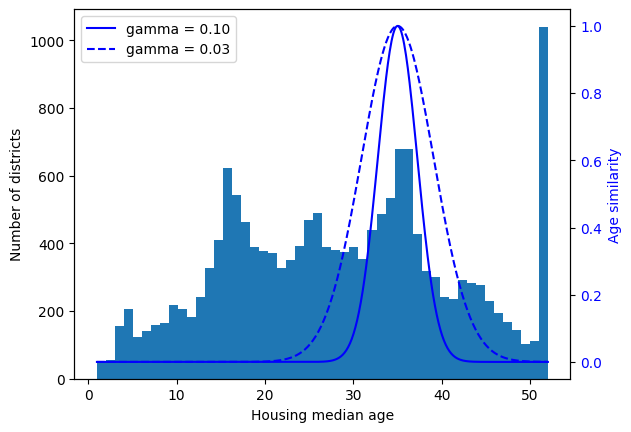

In [19]:
ages = np.linspace(housing['housing_median_age'].min(), housing['housing_median_age'].max(),500).reshape(-1,1)
gamma1 = 0.1
gamma2 = 0.03

rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Housing median age')
ax1.set_ylabel('Number of districts')
ax1.hist(housing['housing_median_age'],bins = 50)

ax2 = ax1.twinx()
color = 'blue'
ax2.plot(ages, rbf1, color=color, label = 'gamma = 0.10')
ax2.plot(ages, rbf2, color=color, label = 'gamma = 0.03', linestyle = '--')
ax2.tick_params(axis='y', labelcolor = color)
ax2.set_ylabel('Age similarity',color = color)

plt.legend(loc = 'upper left')
plt.show()

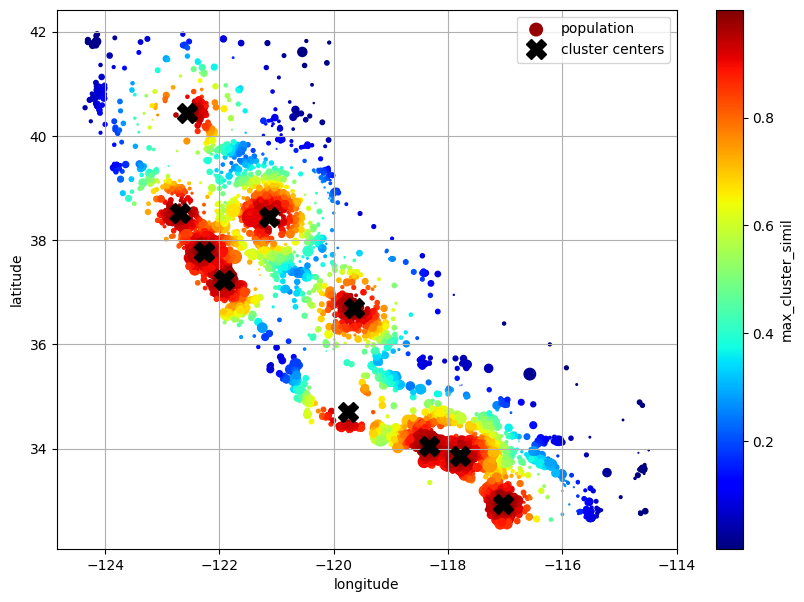

In [20]:
similarity.max(axis=1)
housing['max_cluster_simil'] = similarity.max(axis=1)

housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True,
             s = housing['population']/100, label = 'population', c = 'max_cluster_simil',
             cmap = 'jet', colorbar = True, legend = True, sharex=False, figsize = (10,7))

plt.plot(cluster_simil.kmeans_.cluster_centers_[:,1],
         cluster_simil.kmeans_.cluster_centers_[:,0],
         color='black', marker = 'X', linestyle = "", markersize = 15, label = 'cluster centers')

plt.legend(loc = 'upper right')
plt.show()

In [21]:
# Transformation Pipelines
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

housing_num_prepared = num_pipeline.fit_transform(housing_num)
df_housing_num_prepared = pd.DataFrame(data=housing_num_prepared,
                                       columns=num_pipeline.get_feature_names_out(),
                                       index=housing_num.index)

## Transforming numerical and categorical in efficient way
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)),
    (cat_pipeline, make_column_selector(dtype_include = object))
)

housing_prepared = preprocessing.fit_transform(housing)

In [13]:
# pipeline building

def num_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
)

def cat_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(handle_unknown='ignore')
)

def column_ratio(X):
    return X[:,[0]]/X[:,[1]]

def raio_name(function_tranformer, feature_names_in):
    return ['ratio'] #feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=raio_name),
        StandardScaler()
    )
    
def log_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(np.log, feature_names_out='one-to-one',inverse_func=np.exp),
        StandardScaler()
    )
    
def cluster_simil_pipeline():
    cluster_simil = ClusterSimilarity(n_clusters=10, gamma = 1, random_state=42)
    return cluster_simil
    
preprocessing = ColumnTransformer([
    ('bedroom',ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house',ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house',ratio_pipeline(), ['population', 'households']),
    ('log',log_pipeline(), ['total_bedrooms', 'total_rooms', 'population','households','median_income']),
    ('geo',cluster_simil_pipeline(), ['latitude', 'longitude']),
    ('cat',cat_pipeline(), make_column_selector(dtype_include=object)),
    ],
                                  remainder=num_pipeline()
)


housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [23]:
# selecting and training the model
# Linear model
linear_model = make_pipeline(preprocessing, LinearRegression())
linear_model.fit(housing,housing_label)
housing_prediction = linear_model.predict(housing)
print(r2_score(housing_label, housing_prediction))
print(root_mean_squared_error(housing_label, housing_prediction))

0.6493910878764075
68277.96057553335


In [24]:
# Decision tree model

dtree_model = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
dtree_model.fit(housing,housing_label)
housing_prediction = dtree_model.predict(housing)
print(r2_score(housing_label, housing_prediction))
print(root_mean_squared_error(housing_label, housing_prediction))

tree_rmses = -cross_val_score(dtree_model, housing, housing_label, 
                             scoring = 'neg_root_mean_squared_error', cv = 10)

pd.Series(tree_rmses).describe()

1.0
0.0


count       10.000000
mean     66918.699814
std       1540.144247
min      64106.783139
25%      66045.152633
50%      67101.841335
75%      67596.032236
max      69374.514977
dtype: float64

In [25]:
# random forrest regressor
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_label,
                                scoring = 'neg_root_mean_squared_error', cv = 5)

In [26]:
pd.Series(forest_rmses).describe()

count        5.000000
mean     47035.912583
std        558.011582
min      46268.494517
25%      46876.523682
50%      47054.050417
75%      47160.092931
max      47820.401368
dtype: float64

In [27]:
# Grid Search CV

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor(random_state = 42))
])

param_grid = [
    {'preprocessing__geo__n_clusters':[5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters':[10, 15],
     'random_forest__max_features':[6, 8, 10]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv = 3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_label)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedroom',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<fu...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001BB8370AA20>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [28]:
cv = pd.DataFrame(grid_search.cv_results_)
cv.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,12.634570,0.271618,0.274912,0.019100,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-42941.886425,-43653.898894,-44561.784767,-43719.190029,662.930293,1
13,19.391648,1.695764,0.375995,0.080542,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43283.422588,-43997.988065,-44691.675931,-43991.028861,574.938079,2
14,24.892218,2.910652,0.388627,0.039994,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-43862.655793,-44457.289459,-44970.346078,-44430.097110,452.621262,3
7,12.277482,0.296932,0.338774,0.058737,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44089.536489,-44505.607832,-45277.119596,-44624.087972,492.013934,4
9,12.069340,0.078162,0.276260,0.003549,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44089.536489,-44505.607832,-45277.119596,-44624.087972,492.013934,4


In [38]:
param_dist = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
              'random_forest__max_features':randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_dist, cv = 3, scoring='neg_root_mean_squared_error',
    random_state=42
)
rnd_search.fit(housing, housing_label)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedroom',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_o...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BB838F8DD0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BB83702D50>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [39]:
# analysing best models
final_model = rnd_search.best_estimator_ #includes preprocessing
feature_importance = final_model['random_forest'].feature_importances_
sorted(zip(feature_importance,
       final_model['preprocessing'].get_feature_names_out()),
       reverse=True
    )

[(0.18836603202647126, 'log__median_income'),
 (0.07795960969938898, 'cat__ocean_proximity_INLAND'),
 (0.06110388595864347, 'bedroom__ratio'),
 (0.05772194900488602, 'rooms_per_house__ratio'),
 (0.04569274355282605, 'people_per_house__ratio'),
 (0.041977095119231075, 'geo__Cluster 30 similarity'),
 (0.024893290428216707, 'geo__Cluster 9 similarity'),
 (0.02349145973584661, 'geo__Cluster 36 similarity'),
 (0.021384735075780065, 'geo__Cluster 18 similarity'),
 (0.019231937253583756, 'geo__Cluster 3 similarity'),
 (0.019114201150802552, 'geo__Cluster 32 similarity'),
 (0.01740110192655986, 'geo__Cluster 25 similarity'),
 (0.016281601452371793, 'geo__Cluster 1 similarity'),
 (0.015974756525084677, 'geo__Cluster 26 similarity'),
 (0.014014150061434243, 'geo__Cluster 7 similarity'),
 (0.013588284206905332, 'geo__Cluster 10 similarity'),
 (0.01344850861123562, 'geo__Cluster 12 similarity'),
 (0.013432151644106247, 'geo__Cluster 34 similarity'),
 (0.012971875049373518, 'geo__Cluster 19 similar

In [40]:
# final_prednctions

X_test = htest.drop(['median_house_value'], axis=1)
y_test = htest['median_house_value'].copy()

final_prediction = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_prediction)
print(final_rmse)

41422.168800999665


In [41]:
confidence = .95
squared_error = (final_prediction - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_error) - 1,
                         loc=squared_error.mean(),
                         scale= stats.sem(squared_error)))

array([39272.70918656, 43465.46272048])

In [61]:
joblib.dump(final_model, 'my_california_housing_model.pkl')

['my_california_housing_model.pkl']

In [14]:
# Support vector machine

param_grid = [
    {'svr__kernel':['linear'], 'svr__C':[10, 30, 100 ,300, 100, 3000, 10000, 30000]},
    {'svr__kernel': ['rbf'], 'svr__C':[1,3,10,30, 100, 300, 1000], 'svr__gamma':[0.01, 0.03, 0.1, 0.3, 1, 3]}
]

svr_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('svr', SVR())
])

svr_grid_search = GridSearchCV(svr_pipeline, param_grid, cv = 3, scoring='neg_root_mean_squared_error')
svr_grid_search.fit(housing[:5000], housing_label[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedroom',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<fu...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002007D906EA0>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10, 30, 100, 300, 100, 3000, 10000, 30000],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1, 3, 10, 30, 100, 300, 1000],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1, 3],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [17]:
svr_grid_search_rsme = -svr_grid_search.best_score_
svr_grid_search_rsme

svr_grid_search.best_params_

{'svr__C': 10000, 'svr__kernel': 'linear'}

In [21]:
rnd_param_grid = [{
    'svr__kernel':['linear', 'rbf'],
    'svr__C':loguniform(2, 200000),
    'svr__gamma':expon(scale=1.0)
}]

rnd_search = RandomizedSearchCV(svr_pipeline, rnd_param_grid, cv=3, n_iter=50,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)

rnd_search.fit(housing[:5000], housing_label[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedroom',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_o...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002007D906EA0>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions=[{'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000200682E2660>,
                                         'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002007D7A3140>,
                                         'svr__kernel': ['linear', 'rbf']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [27]:
svr_random_search_rmse = -rnd_search.best_score_
print(svr_random_search_rmse)

print(rnd_search.best_params_)

56135.549824443
{'svr__C': 147845.32281032094, 'svr__gamma': 0.26497040005002437, 'svr__kernel': 'rbf'}


In [31]:
svr_selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector',SelectFromModel(RandomForestRegressor(random_state=42), threshold=-.005)),
    ('svr',SVR(C=rnd_search.best_params_['svr__gamma'],
              gamma=rnd_search.best_params_['svr__gamma'],
              kernel=rnd_search.best_params_['svr__kernel']))
])
                                 
svr_selector_rmse = -cross_val_score(
    svr_selector_pipeline,
    housing[:5000],
    housing_label[:5000],
    scoring='neg_root_mean_squared_error',
    cv=3
)
pd.Series(svr_selector_rmse).describe()

count         3.000000
mean     119786.894964
std        3238.538452
min      116273.159013
25%      118354.300338
50%      120435.441662
75%      121543.762940
max      122652.084217
dtype: float64